# Year 2 Simulations - Focusing on the Tissue in the middle of the probes

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import scipy.ndimage
from scipy.spatial import ConvexHull, Delaunay
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from neurophotonics.sim import Tissue
from neurophotonics import demix, fields
from neurophotonics.demix import SpikeSNR, Sample, Demix, Cosine
from neurophotonics.probe.probely import Probe, ProbeGroup
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

Connecting tdincer84@rds.datajoint.io:3306


In [2]:
import datajoint as dj

## 1. Design Definitions

In [3]:
def design201(save=False, output="Design_v201.csv"):
    # Design 2
    # Create 10 probes at 0, 0, 0
    PG = ProbeGroup(
        [
            Probe(
                probe_dimensions=[1200, 150, 1300],
                n_e_box=[5, 60],
                e_box_length=10,
                e_box_sep=10,
                e_box_vertical_margin=5,
                e_box_horizontal_margin=30,
                n_d_box=[22, 240],
                d_box_length=5,
                d_box_sep=0,
                d_box_vertical_margin=0,
                d_box_horizontal_margin=25,
                name="P" + str(i),
            )
            for i in range(10)
        ]
    )

    # Position the Probes
    for i, probe in enumerate(PG.probes):
        if not i % 2:
            probe.rotate("z", 180)  # Around the origin (0, 0, 0)
            probe.translate([-150.0 * len(PG.probes) / 2 + 0.5 + i * 150.0, 75, 0])
        else:
            probe.translate([-150.0 * len(PG.probes) / 2 + 0.5 + i * 150.0, -75, 0])

    if save:
        df = PG.to_df()
        df.to_csv(output, index=False)

    return PG

In [4]:
D201 = design201()

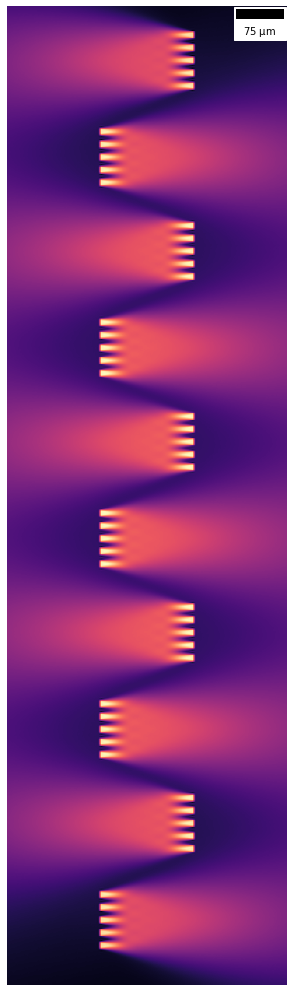

In [126]:
def find_centroids_topNemitters_inZaxis(PG, N):
    topN_centroids = []
    
    default_n = np.array([0, 1, 0])
    topN_angles = []
        
    for probe in PG.probes:
        centroids = np.array([e_pixel.centroid for e_pixel in probe.e_pixels])
        topN_centroids.append(centroids[np.argsort(centroids[:,2])[:N]])
        
        angles = np.arccos(np.dot(probe.e_pixels[0].n, default_n)) * 180 / np.pi
        topN_angles.append(angles)
        
    return np.array(topN_centroids), np.array(topN_angles)
    

def plot(image='topview.npy', PG=D201, N=5):
    fig, ax = plt.subplots(1, 1, figsize=(18, 18)) 
    
    image = np.load('topview.npy')
    topN_centroids, topN_angles = find_centroids_topNemitters_inZaxis(PG=PG, N=N)
    topN_centroids = topN_centroids[:,:,:2]
    
    topN_beams = np.array([scipy.ndimage.shift(scipy.ndimage.rotate(image, angle), [centroids[0] / 2.2, centroids[1] / 2.2]) for probe, angle in zip(topN_centroids, topN_angles) for centroids in probe])
    summed_topNbeams = np.sum(topN_beams, 0)
    summed_topNbeams[summed_topNbeams < 0] = 0
    ax.imshow(summed_topNbeams[120:820, 400:600]**0.7, cmap='magma')
    scalebar = ScaleBar(2.2*1e-6)
    ax.add_artist(scalebar)
    ax.axis('off')
    plt.savefig('Design_201_topview.png')
    plt.show()

plot(image='topview.npy', PG=D201, N=5)

## 2. Tissue in the middle of the shanks overlayed on top of Probes

In [127]:
# Select on the points confined by the Probes.
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [137]:
points = (Tissue & f"design=3").fetch1('cell_xyz')

In [140]:
points

array([[ 555.34512238,  116.3830575 , -633.4453034 ],
       [-210.32640171,  105.10765139, -605.47405478],
       [-328.32076291,   46.80728309, -552.7695005 ],
       ...,
       [ 461.38425561,  -69.92790383,   87.93145947],
       [ 335.76442441,  112.79972628,  367.40106905],
       [  54.171747  ,   24.60697036, -150.56655355]])

Number of spikesnrs: (17506,)
Number of points: (17506, 3)
0.8421486629756155


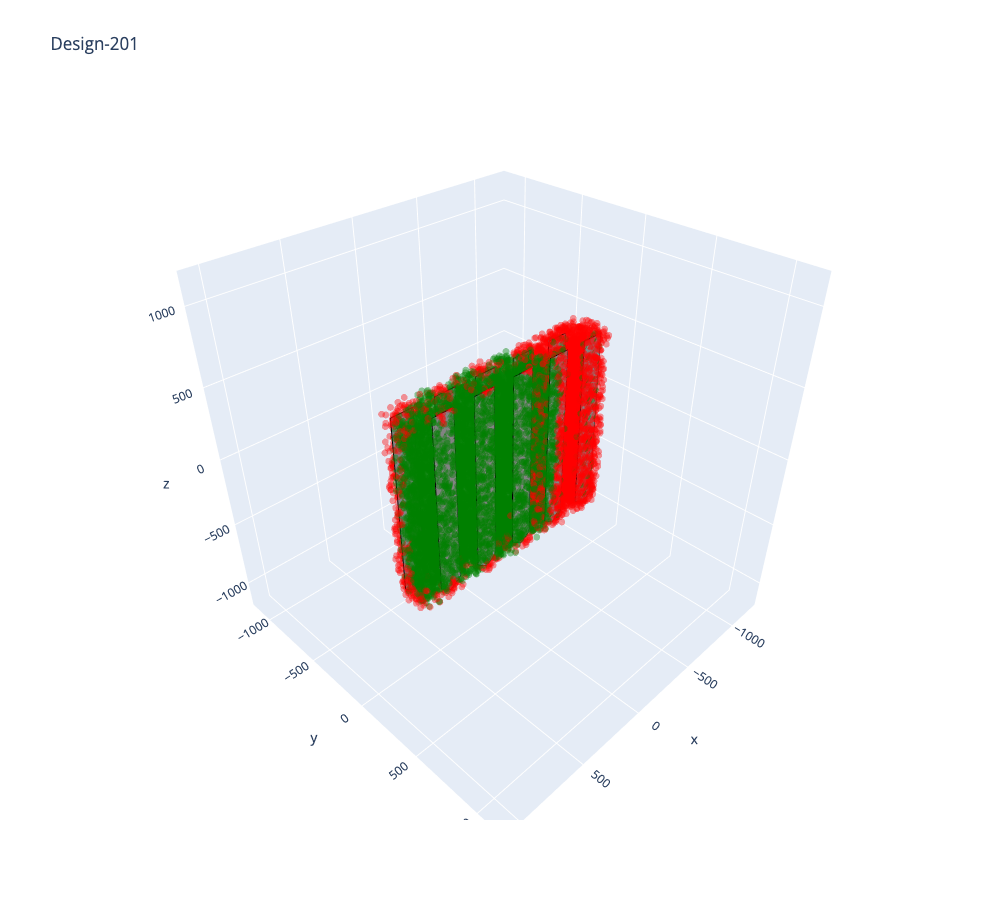

In [147]:
def plot_probes_and_tissues(Designs, sample=3):
    for i, D in enumerate(Designs):
        probe_vertices = np.array([probe.__getattribute__(vert_name) for probe in D.probes for vert_name in ['bl', 'br', 'tl', 'tr']])
        D_hull = ConvexHull(probe_vertices)
        
        selection = (Demix & f"design=3" & f"sample=5").fetch1('selection')

        spike_snrs = (SpikeSNR & f"design=3" & f"sample=5").fetch1('snr')
        print(f"Number of spikesnrs: {spike_snrs.shape}")

        points = (Tissue & f"design=3").fetch1('cell_xyz')
        # print(f"Number of points: {points.shape}")

        points = points[selection]
        print(f"Number of points: {points.shape}")

        is_in_hull = in_hull(points, D_hull.points[D_hull.vertices])
        is_in_hull_indices = np.where(is_in_hull)[0]
        points_inside_the_hull = points[is_in_hull_indices]
        
        points_stat = points_inside_the_hull
        spike_snrs_stat = spike_snrs[is_in_hull_indices]
        #print(len(points_stat))
        
        print(sum(True for x in spike_snrs_stat if x>3)/len(spike_snrs_stat))
        

        fig = go.Figure()
        D.plot_shanks(show=False, cone=False, e_pixels=False, d_pixels=False, fig=fig)
        fig.add_traces(go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], opacity=0.4, mode='markers',
            marker={'size':4, 'color':['green' if x > 3. else 'red' for x in spike_snrs]},showlegend=False)) # df[c].snr.map(lambda x: 'gray' if (x<3) else 'green')
        fig.update_layout(autosize=False, width=900, height=900, title=f"Design-20{i+1}")

        fig.show()

plot_probes_and_tissues([D201])

In [131]:
(Demix & f"design=3").fetch('sample')

array([0, 1, 2, 3, 4, 5, 6])

## 3. SNR achieved vs Density

In [132]:
def SNRforTissueswithintheProbes(Designs, snr_threshold=3, sample=6):
    sep = [30, 60, 120]
    all_snrs = []
    
    sample_length = 6# len((Demix & f"design=3").fetch('sample'))
    
    design_nos = [3]
    for D, design_no in zip(Designs, design_nos):
        probe_vertices = np.array([probe.__getattribute__(vert_name) for probe in D.probes for vert_name in ['bl', 'br', 'tl', 'tr']])
        D_hull = ConvexHull(probe_vertices)
        
        for sample in range(sample_length):
            selection = (Demix & f"design={design_no}" & f"sample={sample}").fetch1('selection')
            spike_snrs = (SpikeSNR & f"design={design_no}" & f"sample={sample}").fetch1('snr')

            points = (Tissue & f"design={design_no}").fetch1('cell_xyz')

            points = points[selection]

            is_in_hull = in_hull(points, D_hull.points[D_hull.vertices])
            is_in_hull_indices = np.where(is_in_hull)[0]
            points_inside_the_hull = points[is_in_hull_indices]

            points_stat = points_inside_the_hull
            spike_snrs_stat = spike_snrs[is_in_hull_indices]
            
            all_snrs.append((sum(True for x in spike_snrs_stat if x > snr_threshold ) / len(spike_snrs_stat)))
    return np.array(all_snrs).reshape(-1, sample_length)

all_snrs_3 = SNRforTissueswithintheProbes([D201], snr_threshold=3, sample=5)


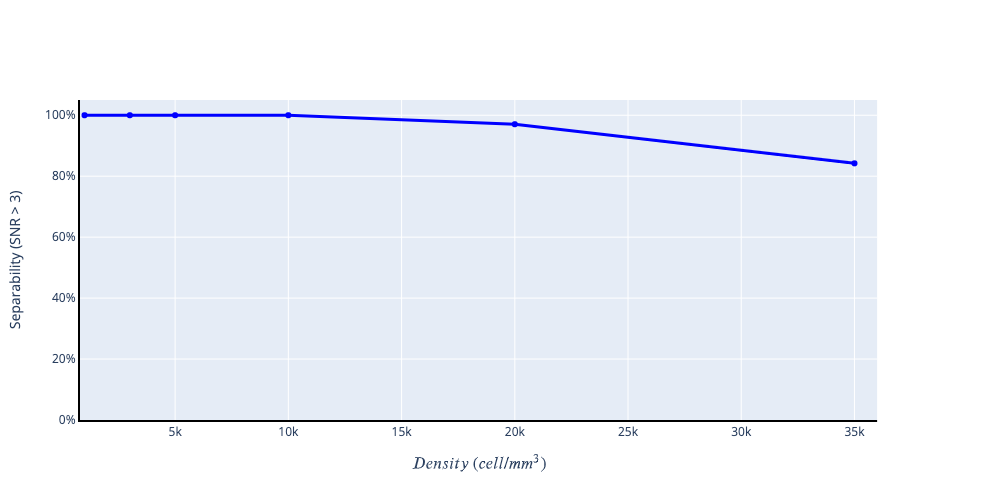

In [133]:
def plot_snr_density():
    density = Sample.fetch("density")

    #colors = ['red', 'green', 'blue']
    colors = ['blue']

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    for i, snrs_3 in enumerate(all_snrs_3):


    #    fig.add_trace(
    #        go.Scatter(x=density, y=snrs_1, mode="lines+markers", name=f"D10{i+1} SNR>1",
    #                   line=dict(color=colors[i], width=3), opacity=0.5,),
    #        secondary_y=False,
    #    )

        fig.add_trace(
            go.Scatter(x=density, y=snrs_3, mode="lines+markers", name=f"D10{i+1} SNR>3",
                       line=dict(color=colors[i], width=3)),
            secondary_y=False, 
        )

    fig.update_layout(
        #xaxis_range=[np.log10(800), np.log10(105_000)],
        xaxis_range=[800, 36_000],
        yaxis_range=[0, 1.05],
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        xaxis_title=r"$Density\ (cell/mm^3)$",
    )
    fig.update_xaxes(showline=True, linewidth=2, linecolor="black")
    fig.update_yaxes(showline=True, linewidth=2, linecolor="black", tickformat=".0%")
    fig.update_yaxes(title_text=r"Separability (SNR > 3)", secondary_y=False) 
    fig.update_layout(autosize=False, width=1000, height=500)
    fig.show()
    
plot_snr_density()


In [ ]:
data = (Cosine * SpikeSNR).fetch(as_dict=True)
density = Sample.fetch('density')

In [ ]:
fig, axs = plt.subplots(3, 9, figsize=(18, 6), sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
for i, (ax, datum) in enumerate(zip(axs.flat[:], data)):
    #probe_vertices = np.array([probe.__getattribute__(vert_name) for probe in D.probes for vert_name in ['bl', 'br', 'tl', 'tr']])
    #D_hull = ConvexHull(probe_vertices)
    
    #points = (Tissue & f"design={i}").fetch1('cell_xyz')
    #selection = (Demix & f"design={i}" & f"sample={sample}").fetch1('selection')

    
    print(datum['design'])
    cos = datum['cosines']
    snr = datum['snr']
    
    cos = np.maximum(cos, 0.0009)
    snr = np.maximum(snr*3, 0.09)
    
    xy = np.vstack([np.log10(snr/cos)/4, np.log10(cos)*4])
    #print(xy)
    z = gaussian_kde(xy)(xy)
    #print(z.max())
    ax.scatter(snr/cos, cos, c=z, s=6, marker='o', lw=0, cmap='plasma', alpha=0.2)
    
    ax.plot([1, 10000], [3, 3/10000], color=[0.2, 0.6, 1.0], linewidth=2, alpha=0.6, ls='-')
    ax.plot([1, 10000], [1, 1/10000], color=[0.2, 0.6, 1.0], linewidth=1, alpha=0.6, ls='--')
    ax.plot([1, 10000], [10, 10/10000], color=[0.2, 0.6, 1.0], linewidth=1, alpha=0.6, ls='--')
    ax.set_xlim([0.01, 3.05e4])
    ax.set_ylim([0.03, 1.2])
    ax.set_yscale('log')
    ax.set_xscale('log')
    #ax.set_aspect('equal')
    if i < 9:
        ax.set_title('{density} cells/mm$^2$'.format(density=density[i%9]))

#plt.tight_layout()
plt.show()
#fig.savefig('results.png')
   